### notebook from unet4nuclei-master

# Step 01
# Preprocessing input images and annotations

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import pathlib
from tqdm import tqdm

import skimage.io
import skimage.segmentation

# import utils.dirtools (optional)
# import utils.augmentation (optional)


# Configuration

In [3]:
WORKING_DIR = "/Users/thuang/Documents/Personal/code/microscopy-with-ml"
os.chdir(WORKING_DIR)
print(f"Working directory: {os.getcwd()}")

DATA_ROOT_PATH = "data"

config_vars = {
    'augment_images': True,
    'batch_size': 10,
    'boundary_boost_factor': 1,
    'boundary_labels_dir': os.path.join(DATA_ROOT_PATH, 'boundary_labels'),
    'boundary_size': 2,
    'cell_min_size': 16,
    'create_split_files': False,
    'crop_size': 256,
    'elastic_augmentations': 10,
    'elastic_distortion': 5,
    'elastic_points': 16,
    'epochs': 15,
    'learning_rate': 0.0001,
    'max_training_images': 2,
    'min_nucleus_size': 25,
    'normalized_images_dir': os.path.join(DATA_ROOT_PATH, 'norm_images'),
    'object_dilation': 3,
    'path_files_test': '/home/jccaicedo/segmentation/test.txt',
    'path_files_training': '/home/jccaicedo/segmentation/training.txt',
    'path_files_validation': '/home/jccaicedo/segmentation/validation.txt',
    'pixel_depth': 8,
    'raw_annotations_dir': os.path.join(DATA_ROOT_PATH, 'masks'),
    'raw_images_dir': os.path.join(DATA_ROOT_PATH, 'images'),
    'rescale_labels': True,
    'root_directory': '/home/jccaicedo/segmentation/',
    'steps_per_epoch': 500,
    'training_fraction': 0.5,
    'transform_images_to_PNG': True,
    'val_batch_size': 10,
    'validation_fraction': 0.25
    }

print(f"raw_images_dir: {config_vars['raw_images_dir']}")
print(f"raw_annotations_dir: {config_vars['raw_annotations_dir']}")
print(f"normalized_images_dir: {config_vars['normalized_images_dir']}")
print(f"boundary_labels_dir: {config_vars['boundary_labels_dir']}")


Working directory: /Users/thuang/Documents/Personal/code/microscopy-with-ml
raw_images_dir: data/images
raw_annotations_dir: data/masks
normalized_images_dir: data/norm_images
boundary_labels_dir: data/boundary_labels


# Data partitions

In [4]:
# Prepare split files

# if config_vars["create_split_files"]:
#     file_list = os.listdir(config_vars["raw_images_dir"])

#     [list_training, list_test, list_validation] = utils.dirtools.create_image_lists(
#         config_vars["raw_images_dir"],
#         config_vars["training_fraction"],
#         config_vars["validation_fraction"]
#     )

#     utils.dirtools.write_path_files(config_vars["path_files_training"], list_training)
#     utils.dirtools.write_path_files(config_vars["path_files_test"], list_test)
#     utils.dirtools.write_path_files(config_vars["path_files_validation"], list_validation)
    
# data_partitions = utils.dirtools.read_data_partitions(config_vars, load_augmented=False)

In [3]:
# Create output directories for transformed data
os.makedirs(config_vars["normalized_images_dir"], exist_ok=True)
os.makedirs(config_vars["boundary_labels_dir"], exist_ok=True)

# Image Preprocessing

In [11]:
if config_vars["transform_images_to_PNG"]:
    
    filelist = sorted(os.listdir(config_vars["raw_images_dir"]))

    # run over all raw images
    for filename in tqdm(filelist):

        # load image and its annotation
        orig_img = skimage.io.imread(config_vars["raw_images_dir"] + '/' + filename)       

        # IMAGE

        # normalize to [0,1]
        percentile = 99.9
        high = np.percentile(orig_img, percentile)
        low = np.percentile(orig_img, 100-percentile)

        img = np.minimum(high, orig_img)
        img = np.maximum(low, img)

        img = (img - low) / (high - low) # gives float64, thus cast to 8 bit later
        img = skimage.img_as_ubyte(img) 

        skimage.io.imsave(config_vars["normalized_images_dir"] +'/'+ filename[:-3] + 'png', img)    
# else:
#     config_vars["normalized_images_dir"] = config_vars["raw_images_dir"]

100%|██████████| 200/200 [00:07<00:00, 28.55it/s]


uint8 (520, 696)


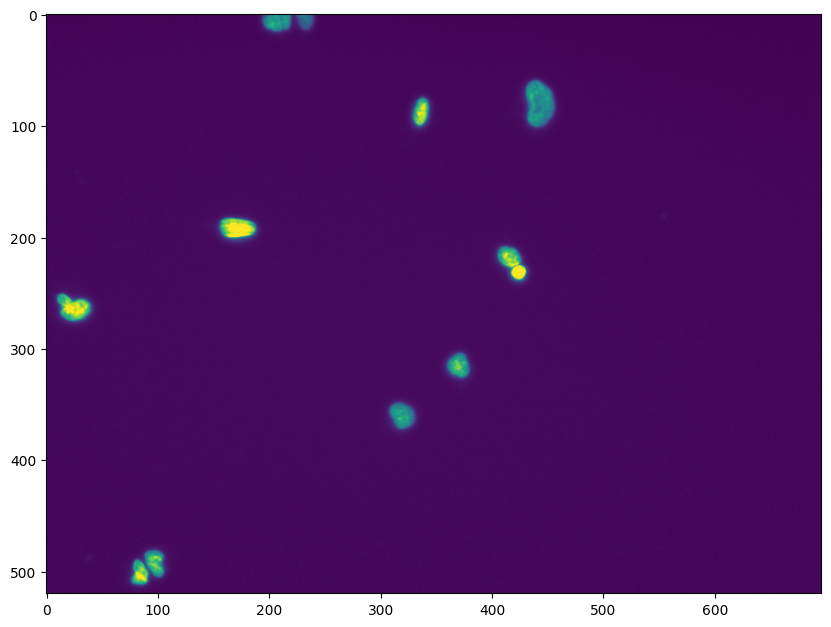

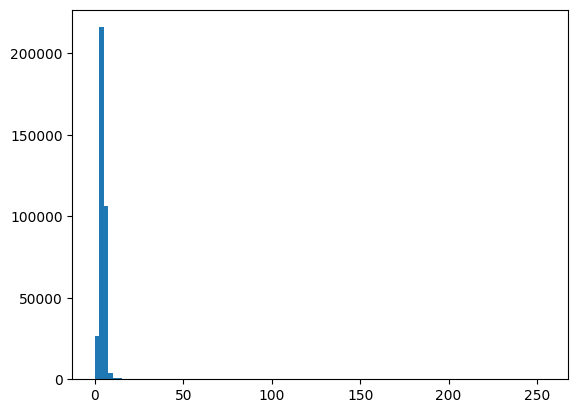

In [14]:
print(img.dtype, img.shape)
filename = os.listdir(config_vars["normalized_images_dir"])
img = skimage.io.imread(config_vars["normalized_images_dir"] +'/'+ filename[5])
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()
plt.hist(img.flatten(), bins=100)
plt.show()

# Create Output Targets: Three Class Boundary

In [11]:
filelist = sorted(os.listdir(config_vars["raw_annotations_dir"]))
total_objects = 0

# run over all raw images
for filename in tqdm(filelist):
    
    # GET ANNOTATION
    annot = skimage.io.imread(config_vars["raw_annotations_dir"] +'/'+ filename)
    
    # strip the first channel
    if len(annot.shape) == 3:
        annot = annot[:,:,0]
    
    # label the annotations nicely to prepare for future filtering operation
    annot = skimage.morphology.label(annot)
    total_objects += len(np.unique(annot)) - 1
    
    # filter small objects, e.g. micronulcei
    annot = skimage.morphology.remove_small_objects(annot, min_size=config_vars["min_nucleus_size"])
    
    # find boundaries
    boundaries = skimage.segmentation.find_boundaries(annot)

    for k in range(2, config_vars["boundary_size"], 2):
        boundaries = skimage.morphology.binary_dilation(boundaries)
        
    # BINARY LABEL
    
    # prepare buffer for binary label
    label_binary = np.zeros((annot.shape + (3,))) # 3 channel image for PNG
    
    # write binary label
    label_binary[(annot == 0) & (boundaries == 0), 0] = 1 # channel 0: background = 1
    label_binary[(annot != 0) & (boundaries == 0), 1] = 1 # channel 1: nuclei but not boundaries = 1
    label_binary[boundaries == 1, 2] = 1 # channel 2: boundaries = 1
    
    # save it - converts image to range from 0 to 255
    skimage.io.imsave(config_vars["boundary_labels_dir"] +'/'+ filename, (label_binary*255).astype(np.uint8))
    
print("Total objects: ",total_objects)

 34%|███▎      | 67/200 [00:02<00:04, 28.17it/s]/Users/thuang/Documents/Personal/code/microscopy-with-ml/venv/lib/python3.11/site-packages/skimage/_shared/utils.py:328: UserWarning: data/boundary_labels/IXMtest_F13_s7_w13C1B1D8C-293E-454F-B0FD-6C2C3F9F5173.png is a low contrast image
  return func(*args, **kwargs)
 68%|██████▊   | 137/200 [00:05<00:02, 26.82it/s]/Users/thuang/Documents/Personal/code/microscopy-with-ml/venv/lib/python3.11/site-packages/skimage/_shared/utils.py:328: UserWarning: data/boundary_labels/IXMtest_L01_s2_w1E5038251-DBA3-44D0-BC37-E43E2FC8C174.png is a low contrast image
  return func(*args, **kwargs)
 72%|███████▏  | 144/200 [00:05<00:02, 26.84it/s]/Users/thuang/Documents/Personal/code/microscopy-with-ml/venv/lib/python3.11/site-packages/skimage/_shared/utils.py:328: UserWarning: data/boundary_labels/IXMtest_L10_s6_w12D12D64C-2639-4CA8-9BB4-99F92C9B7068.png is a low contrast image
  return func(*args, **kwargs)
100%|██████████| 200/200 [00:07<00:00, 27.47it/s]

Total objects:  23615


int64 (520, 696)


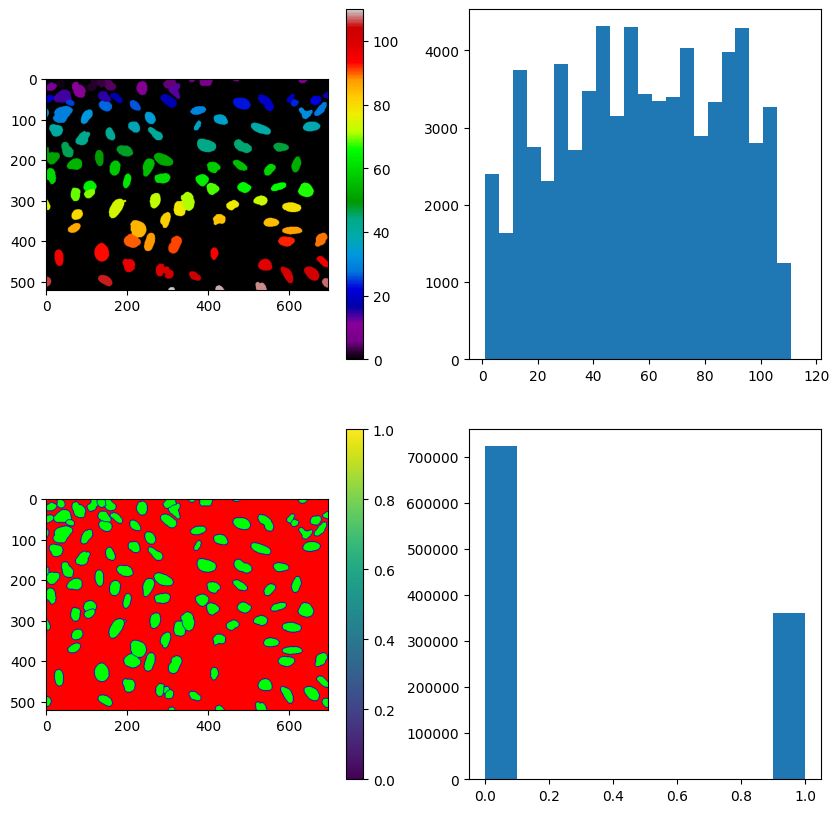

In [ ]:
# Show example image 
print(annot.dtype, annot.shape)

plt.subplots(2,2, figsize=(10,10))

# plot original annotation
plt.subplot(2,2,1)
plt.imshow(annot, cmap="nipy_spectral")
plt.colorbar()

# plot histogram of annotation
plt.subplot(2,2,2)
plt.hist(annot.flatten(), bins=range(1,120,5))

# plot boundary labels
plt.subplot(2,2,3)
plt.imshow(label_binary)
plt.colorbar()

# plot histogram of boundary labels
plt.subplot(2,2,4)
plt.hist(label_binary.flatten(),)

plt.show()

# Augmentation
